In [1]:
!pip install mpi4py

In [2]:
import gdown
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

In [3]:
os.makedirs("imgs", exist_ok=True)
os.makedirs("mpi_imgs", exist_ok=True)

In [4]:
url = "https://drive.google.com/file/d/1k5PDQW210Ge7jc9HriwKM4t-uk6DSjZw/view?usp=sharing"
output = "sea.png"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1k5PDQW210Ge7jc9HriwKM4t-uk6DSjZw
To: /content/sea.png
100%|██████████| 137k/137k [00:00<00:00, 42.1MB/s]


'sea.png'

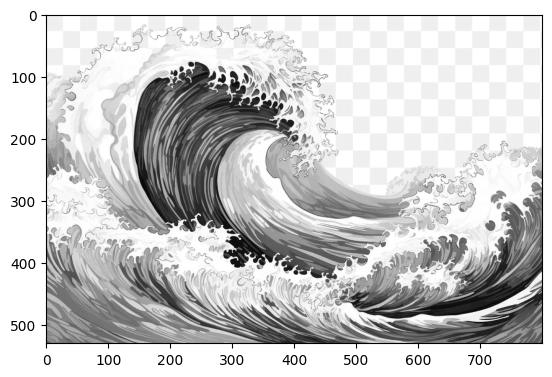

In [5]:
image = cv2.imread(output, 0)
plt.imshow(image, cmap='gray')

In [6]:
def shift_image(image, n=1):
    buffer = np.empty(image.shape, dtype=np.uint8)
    buffer[:, n:] = image[:, :-n]
    buffer[:, :n] = image[:, -n:]

    return buffer

def apply_shifts(image):
    shifted_image = image
    for i in range(300):
        cv2.imwrite(f'imgs/single_image{i}.png', shifted_image)
        shifted_image = shift_image(shifted_image)

In [7]:
apply_shifts(image)

In [8]:
def get_images():
    images = []
    for i in range(300):
        image = cv2.imread(f'imgs/single_image{i}.png', cv2.IMREAD_UNCHANGED)
        images.append(image)
    return images

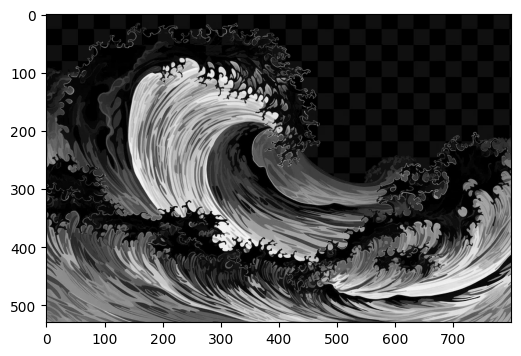

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
images = get_images()
def animate(frame):
    ax.clear()

    img = ax.imshow(images[frame], cmap=cm.binary)
    return [img]

anim = animation.FuncAnimation(fig, animate, frames=300, interval=2, blit=True, repeat=True)
plt.show()

In [10]:
anim.save('animation.gif')

In [11]:
%%writefile shift.py
from mpi4py import MPI
import numpy as np
import cv2
import sys

comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

root = 0
N_global = int(sys.argv[3])
L = int(sys.argv[2])
my_N = N_global // size
remainder = N_global % size
my_buffer = np.empty(L, dtype=np.uint8)

id_left_neighbour  = (size + rank - 1) % size
id_right_neighbour = (rank + 1) % size

if (rank < remainder):
    my_N = my_N + 1

if rank == root:
    image = cv2.imread(sys.argv[1], cv2.IMREAD_GRAYSCALE)
    arrays = np.array_split(image.T, size)
    for i, array in enumerate(arrays[1:]):
        comm.Send(array.reshape(-1, ), dest=i+1, tag=i)
    my_part = arrays[0]

else:
    my_part = np.empty((my_N*L, ), dtype=np.uint8)
    comm.Recv([my_part, my_N * L, MPI.INT], source=root, tag=rank-1)
    my_part = my_part.reshape(my_N, -1)

for i in range(300):
    comm.Send(np.ascontiguousarray(my_part[-1]), dest=id_right_neighbour, tag=0)
    my_part[1:] = my_part[:-1].copy()
    comm.Recv([my_buffer[:], L, MPI.INT], source=id_left_neighbour, tag=0)
    my_part[0] = my_buffer.copy()

    imgs = comm.gather(my_part, root=root)
    if rank == root:
        for j, img in enumerate(imgs):
            cv2.imwrite(f'mpi_imgs/{i}_{j}.png', img)

        cv2.imwrite(f'mpi_imgs/{i}_all.png', np.concatenate(imgs, axis=0).T)
        cv2.imwrite(f'mpi_imgs/multi_image{i}.png', np.concatenate(imgs, axis=0).T)

MPI.Finalize()

Overwriting shift.py


In [12]:
!mpirun -n 8 --allow-run-as-root --oversubscribe python shift.py 'sea.png' 530 800

In [13]:
def get_images():
    images = []
    for i in range(300):
        image = cv2.imread(f'mpi_imgs/multi_image{i}.png', 0)
        images.append(image)
    return images

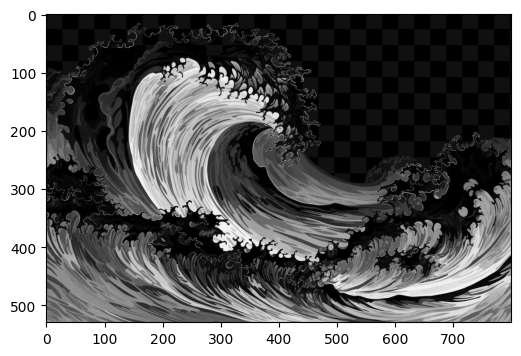

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
images = get_images()
def animate(frame):
    ax.clear()

    img = ax.imshow(images[frame], cmap=cm.binary)
    return [img]

anim = animation.FuncAnimation(fig, animate, frames=300, interval=2, blit=True, repeat=True)
plt.show()

anim.save('animation1.gif')